# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [66]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
%matplotlib inline

In [67]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [68]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [69]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [70]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [71]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [72]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation

In [73]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [74]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,117,3600,3600,0.0,0.0,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,36,36,36,13,7,30,1043,1034,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2019-08,2020-05,2019-10,2018-12,2018-08,2019-01-20,2021-04-02,2020-11-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1048,121,122,324,616,9,10,9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4989.978500,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2890.668601,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2465.750000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4980.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7489.000000,NaN


In [75]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [76]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [77]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [78]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [79]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [80]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     4832
3.0     4610
1.0     4311
4.0     4133
0.0     3395
5.0     3254
6.0     2780
7.0     2277
8.0     1747
9.0     1410
10.0    1131
11.0     744
12.0     493
13.0     364
14.0     184
15.0     133
16.0      77
17.0      53
18.0      34
19.0      25
20.0       8
21.0       2
24.0       1
22.0       1
25.0       1
Name: CCI, dtype: int64

In [81]:
data.age_cat

0         5-14
1          0-4
2        45-54
3         5-14
4        45-54
         ...  
35995    35-44
35996      0-4
35997     5-14
35998    15-24
35999    15-24
Name: age_cat, Length: 36000, dtype: object

In [82]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi'], right=False, bins=[0,18.5,25,30,200], labels=['Low', 'Moderate', 'High', 'very high'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,7,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

## 2- Plots

### 2-1- Continuous factors

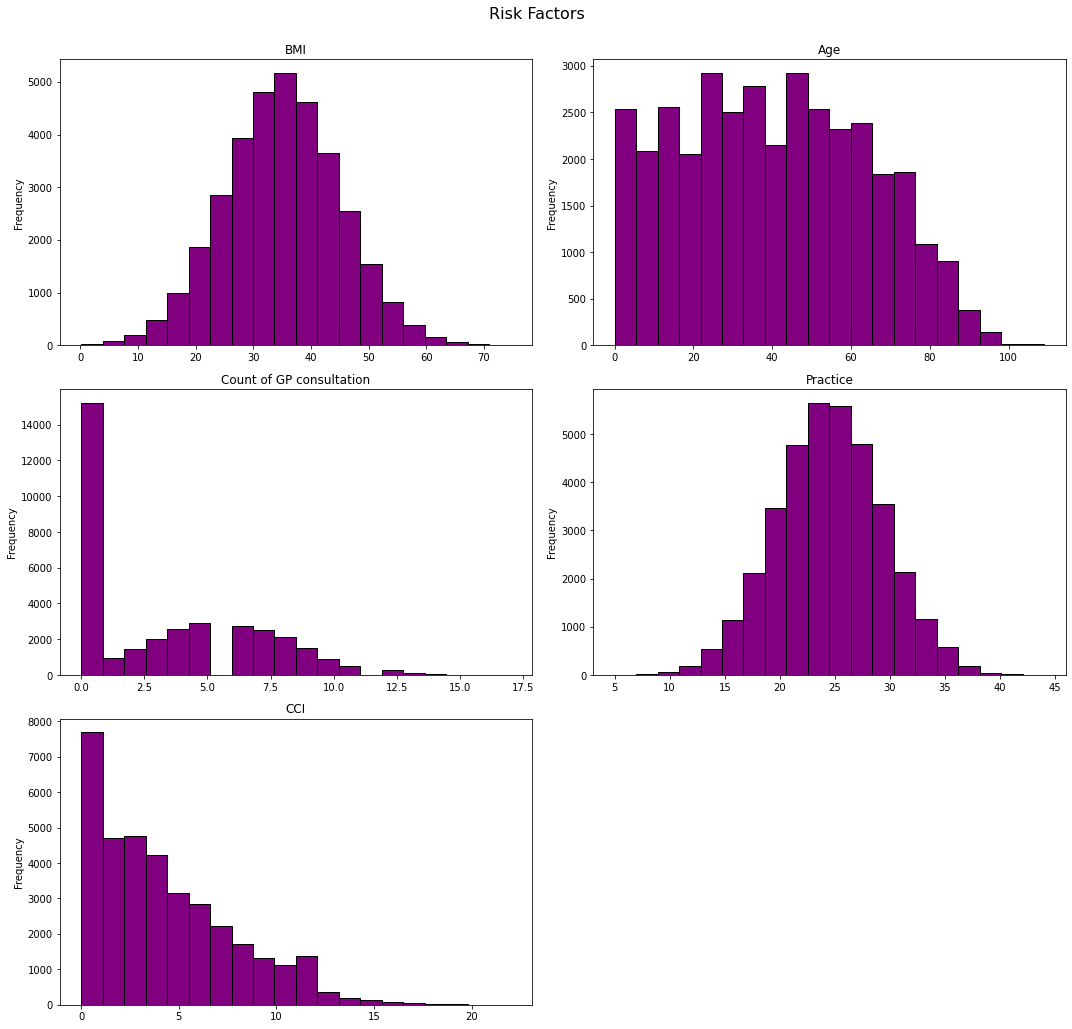

In [17]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [86]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

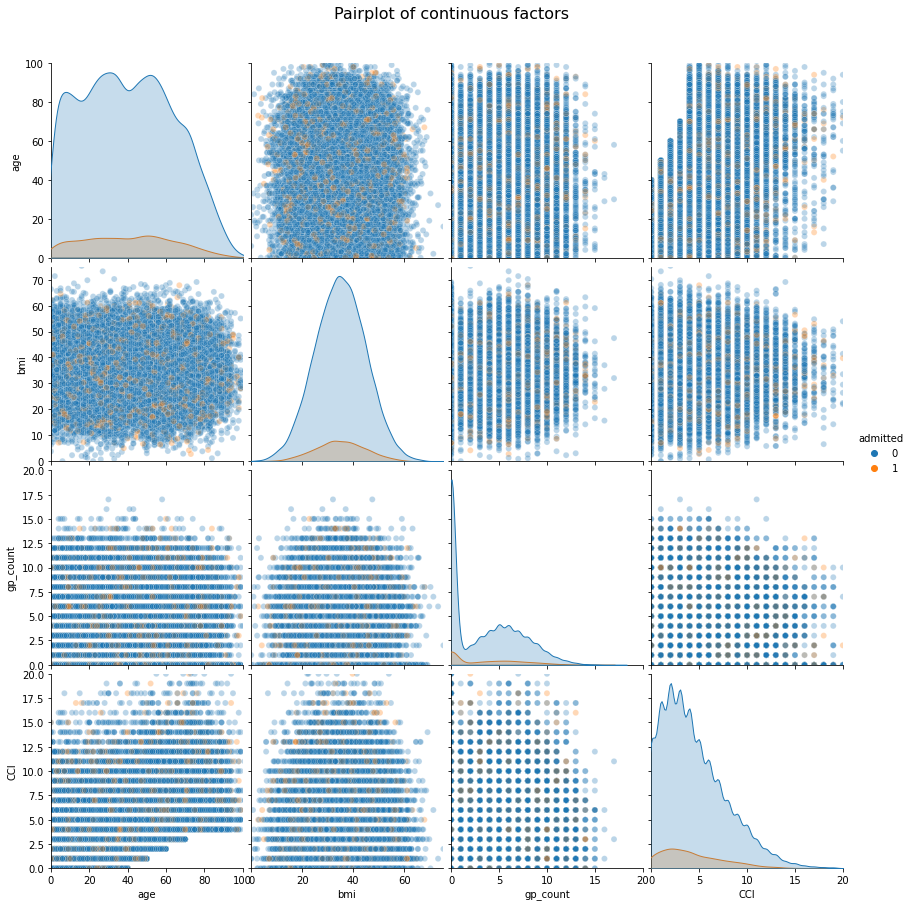

In [89]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_prescriptions', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

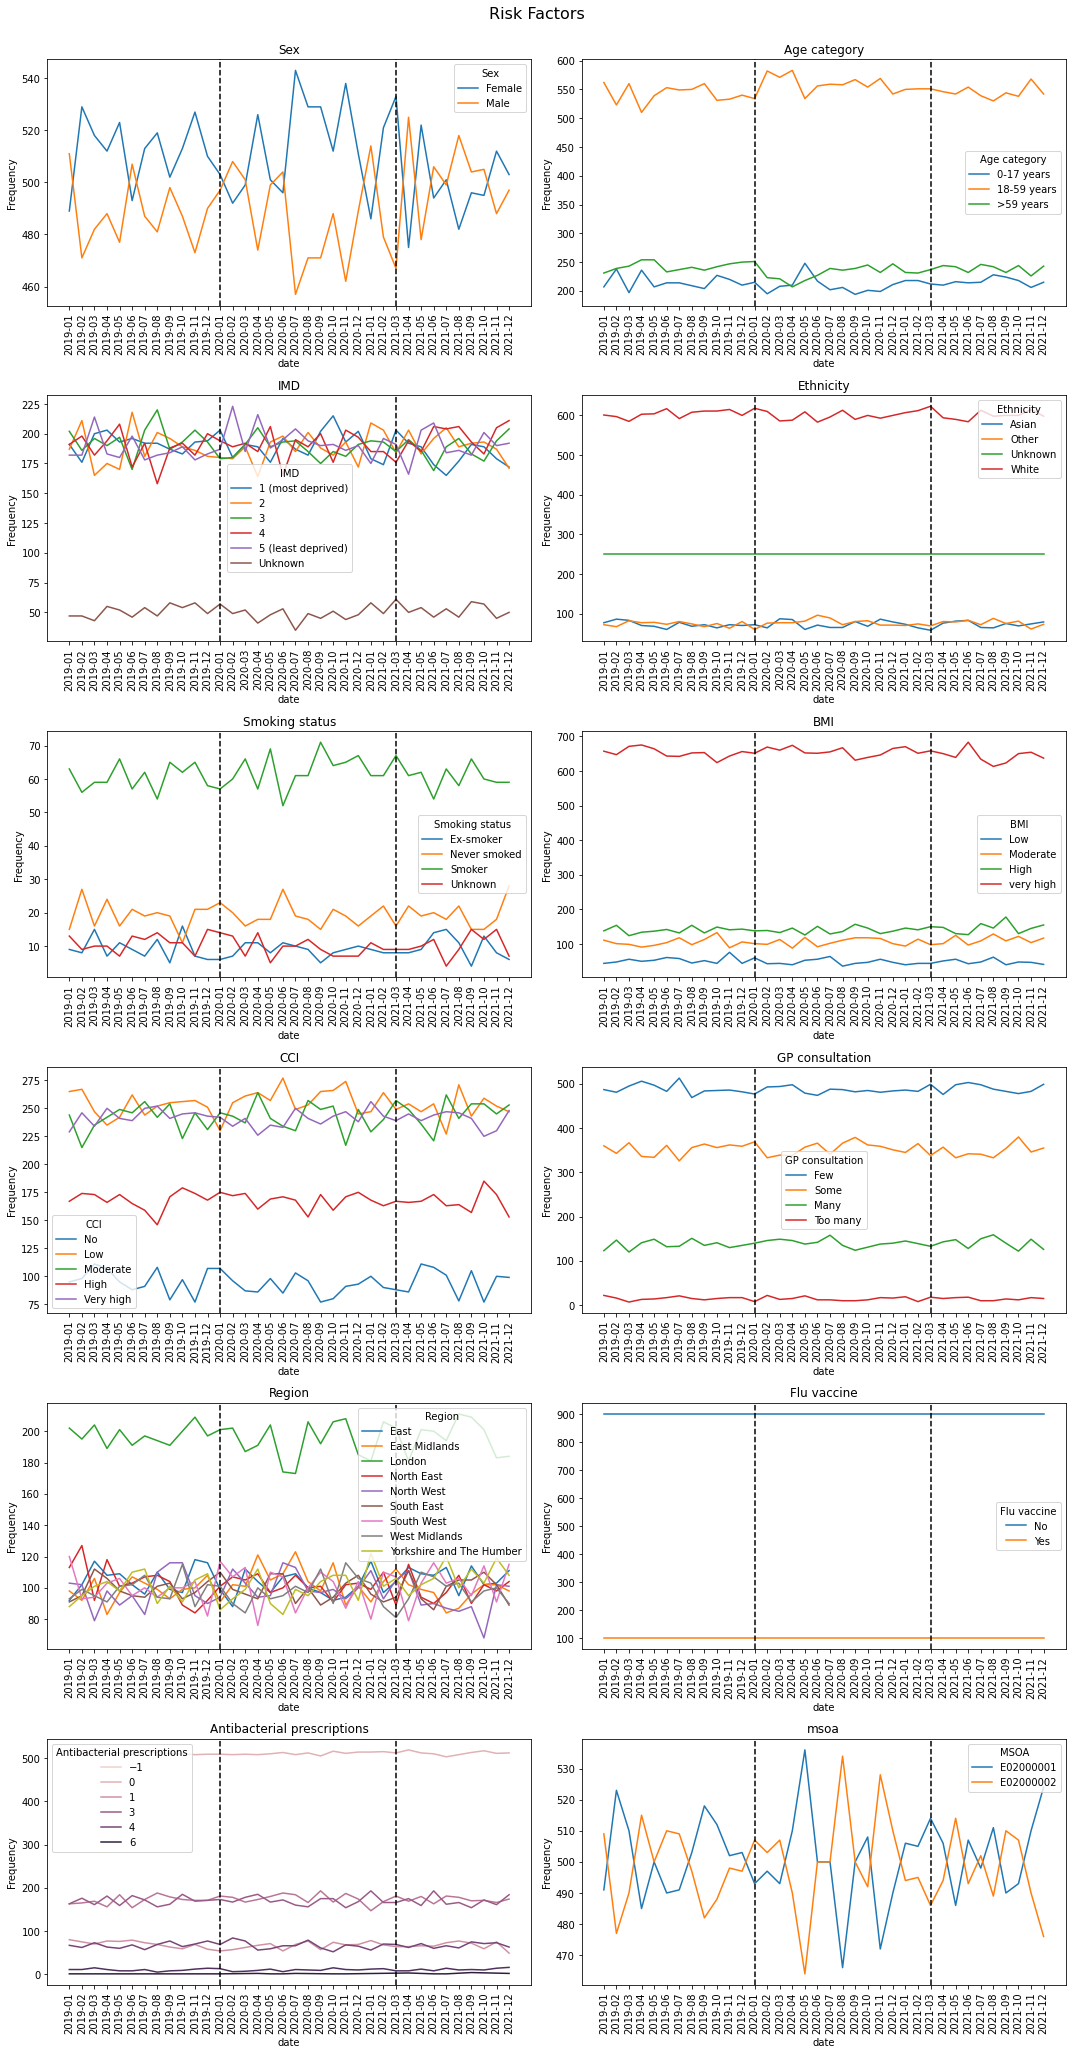

In [18]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Hospital admissions related to infections 

### 3-1- Data preparation for hospital admission prediction with negative binomial regression
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission. 

In [90]:
data['uti_date_1'] = data['uti_date_1'].astype('datetime64[ns]')
data['uti_date_2'] = data['uti_date_2'].astype('datetime64[ns]')
data['uti_date_3'] = data['uti_date_3'].astype('datetime64[ns]')
data['uti_date_4'] = data['uti_date_4'].astype('datetime64[ns]')

data['lrti_date_1'] = data['lrti_date_1'].astype('datetime64[ns]')
data['lrti_date_2'] = data['lrti_date_2'].astype('datetime64[ns]')
data['lrti_date_3'] = data['lrti_date_3'].astype('datetime64[ns]')
data['lrti_date_4'] = data['lrti_date_4'].astype('datetime64[ns]')

data['primary_care_covid'] = data['primary_care_covid'].astype('datetime64[ns]')
data['sgss_positive'] = data['sgss_positive'].astype('datetime64[ns]')
data['admitted_date'] = data['admitted_date'].astype('datetime64[ns]')

In [91]:
data['delta_uti_1_admitted'] = (data['admitted_date'] - data['uti_date_1']).dt.days
data['delta_uti_2_admitted'] = (data['admitted_date'] - data['uti_date_2']).dt.days
data['delta_uti_3_admitted'] = (data['admitted_date'] - data['uti_date_3']).dt.days
data['delta_uti_4_admitted'] = (data['admitted_date'] - data['uti_date_4']).dt.days

data['delta_lrti_1_admitted'] = (data['admitted_date'] - data['lrti_date_1']).dt.days
data['delta_lrti_2_admitted'] = (data['admitted_date'] - data['lrti_date_2']).dt.days
data['delta_lrti_3_admitted'] = (data['admitted_date'] - data['lrti_date_3']).dt.days
data['delta_lrti_4_admitted'] = (data['admitted_date'] - data['lrti_date_4']).dt.days

In [92]:
data['delta_uti_1_admitted'] = data['delta_uti_1_admitted'][(data['delta_uti_1_admitted'] < 30) & (data['delta_uti_1_admitted'] > 0)]
data['delta_uti_2_admitted'] = data['delta_uti_2_admitted'][(data['delta_uti_2_admitted'] < 30) & (data['delta_uti_2_admitted'] > 0)]
data['delta_uti_3_admitted'] = data['delta_uti_3_admitted'][(data['delta_uti_3_admitted'] < 30) & (data['delta_uti_3_admitted'] > 0)]
data['delta_uti_4_admitted'] = data['delta_uti_4_admitted'][(data['delta_uti_4_admitted'] < 30) & (data['delta_uti_4_admitted'] > 0)]

data['delta_lrti_1_admitted'] = data['delta_lrti_1_admitted'][(data['delta_lrti_1_admitted'] < 30) & (data['delta_lrti_1_admitted'] > 0)]
data['delta_lrti_2_admitted'] = data['delta_lrti_2_admitted'][(data['delta_lrti_2_admitted'] < 30) & (data['delta_lrti_2_admitted'] > 0)]
data['delta_lrti_3_admitted'] = data['delta_lrti_3_admitted'][(data['delta_lrti_3_admitted'] < 30) & (data['delta_lrti_3_admitted'] > 0)]
data['delta_lrti_4_admitted'] = data['delta_lrti_4_admitted'][(data['delta_lrti_4_admitted'] < 30) & (data['delta_lrti_4_admitted'] > 0)]

In [93]:
data['Infection_count'] = np.nan
col0 = data.columns.get_loc('Infection_count')

col1 = data.columns.get_loc('delta_uti_1_admitted')
col2 = data.columns.get_loc('delta_uti_2_admitted')
col3 = data.columns.get_loc('delta_uti_3_admitted')
col4 = data.columns.get_loc('delta_uti_4_admitted')
col5 = data.columns.get_loc('delta_lrti_1_admitted')
col6 = data.columns.get_loc('delta_lrti_2_admitted')
col7 = data.columns.get_loc('delta_lrti_3_admitted')
col8 = data.columns.get_loc('delta_lrti_4_admitted')


for idx, x in enumerate(data['Infection_count']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] > 0:
        n=n+1
    if data.iat[idx, col2] > 0:
        n=n+1 
    if data.iat[idx, col3] > 0:
        n=n+1 
    if data.iat[idx, col4] > 0:
        n=n+1
    if data.iat[idx, col5] > 0:
        n=n+1
    if data.iat[idx, col6] > 0:
        n=n+1
    if data.iat[idx, col7] > 0:
        n=n+1
    if data.iat[idx, col8] > 0:
        n=n+1
    data.iat[idx, col0]=n

data.Infection_count.value_counts()

# data.loc[data.Infection_count == 2]

0.0    35768
1.0      227
2.0        5
Name: Infection_count, dtype: int64

In [94]:
# add a column with the closest duration from hospitalisation
data['Infection_admitted_min_delta'] = data[['delta_uti_1_admitted','delta_uti_2_admitted', 'delta_uti_3_admitted', 
                                            'delta_uti_4_admitted', 'delta_lrti_1_admitted', 'delta_lrti_2_admitted',
                                            'delta_lrti_3_admitted', 'delta_lrti_4_admitted']].min(axis=1)

data['Infection_admitted_min_delta'].value_counts().sum()

232

In [216]:
#data['Infection_admitted_min_delta'].value_counts()

In [101]:
print(f'Data shape is: {data.shape}')

Data shape is: (36000, 93)


In [102]:
# calculation of delta of hospital admission date and sgss diagnosis of covid
#data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['primary_care_covid']).dt.days
data['delta_sgss_covid_admitted'] = (data['admitted_date'] - data['sgss_positive']).dt.days
data['delta_sgss_covid_admitted'].value_counts()

 42.0     5
 144.0    4
-142.0    4
-167.0    4
 201.0    4
         ..
-10.0     1
-499.0    1
-77.0     1
-722.0    1
 292.0    1
Name: delta_sgss_covid_admitted, Length: 800, dtype: int64

In [103]:
data['delta_sgss_covid_admitted'].value_counts().sum()

1112

In [104]:
data['delta_sgss_covid_admitted'] = data['delta_sgss_covid_admitted'][(data['delta_sgss_covid_admitted'] < 390) & (data['delta_sgss_covid_admitted'] > -390)]
data['delta_sgss_covid_admitted'].value_counts().sum()

639

In [105]:
# calculate absolute values for all rows in delta_primary_care_covid_admitted column
data['delta_sgss_covid_admitted_abs'] = data['delta_sgss_covid_admitted'].abs()

data['delta_sgss_covid_admitted_abs'].value_counts()

5.0      7
42.0     6
199.0    6
201.0    5
142.0    5
        ..
193.0    1
94.0     1
107.0    1
148.0    1
43.0     1
Name: delta_sgss_covid_admitted_abs, Length: 311, dtype: int64

In [106]:
data['delta_sgss_covid_admitted_abs'].value_counts().sum()

639

In [107]:
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_abs'].mask(data['delta_sgss_covid_admitted_abs'] > 0, 1)
data['delta_sgss_covid_admitted_binary'] = data['delta_sgss_covid_admitted_binary'].fillna(0)
data['delta_sgss_covid_admitted_binary'].sum()
# data['delta_sgss_covid_admitted_binary'].value_counts()

639.0

In [108]:
data['delta_sgss_covid_admitted_binary'].value_counts()

0.0    35361
1.0      639
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [109]:
#data.Infection_admitted_min_delta.value_counts()#.sum()

In [110]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    35361
1.0      639
Name: delta_sgss_covid_admitted_binary, dtype: int64

In [111]:
data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'] = np.nan
col0 = data.columns.get_loc('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary')

col1 = data.columns.get_loc('Infection_admitted_min_delta')
col2 = data.columns.get_loc('delta_sgss_covid_admitted_binary')


for idx, x in enumerate(data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary']):
    n=0
    #comorbidity component
    if data.iat[idx, col1] >= 1 and data.iat[idx, col2] == 1:
        n=n+1
    data.iat[idx, col0]=n

data['Infection_admitted_min_delta_delta_sgss_covid_admitted_binary'].value_counts()

# data.loc[data.Infection_count == 2]

0.0    35986
1.0       14
Name: Infection_admitted_min_delta_delta_sgss_covid_admitted_binary, dtype: int64

In [112]:
data.delta_sgss_covid_admitted_binary.value_counts()

0.0    35361
1.0      639
Name: delta_sgss_covid_admitted_binary, dtype: int64

### 3-2- Plots of hospitalisation

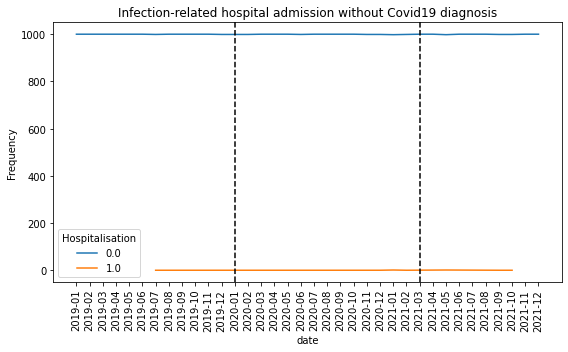

In [113]:
fig, ax = plt.subplots(figsize=(8, 5))

create_lineplot('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', ax)

plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation.jpg')
plt.show()

### 3-3- Data inclusions and exclusions

In [114]:
# inclusion applied
data_inclusions = data[data['Infection_admitted_min_delta'].notnull()]
print(f'The shape of data with hospitalisation inclusion criterion is: {data_inclusions.shape}')

The shape of data with hospitalisation inclusion criterion is: (232, 95)


In [115]:
# exclusion applied
data_inclusions_exlusions = data_inclusions[(data_inclusions['delta_sgss_covid_admitted'] < 390) & (data_inclusions['delta_sgss_covid_admitted'] > -390)]  # exclusions shold be <90  and >-30
print(f'The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: {data_inclusions_exlusions.shape}')

The shape of data with hospitalisation inclusion criterion and covid diagnosis (sgss) exclusion criterion is: (14, 95)


In [116]:
data_inclusions_exlusions['delta_sgss_covid_admitted'].value_counts()

-165.0    1
 149.0    1
-71.0     1
-187.0    1
-24.0     1
 231.0    1
 52.0     1
 227.0    1
 244.0    1
-19.0     1
-275.0    1
-137.0    1
-64.0     1
-125.0    1
Name: delta_sgss_covid_admitted, dtype: int64

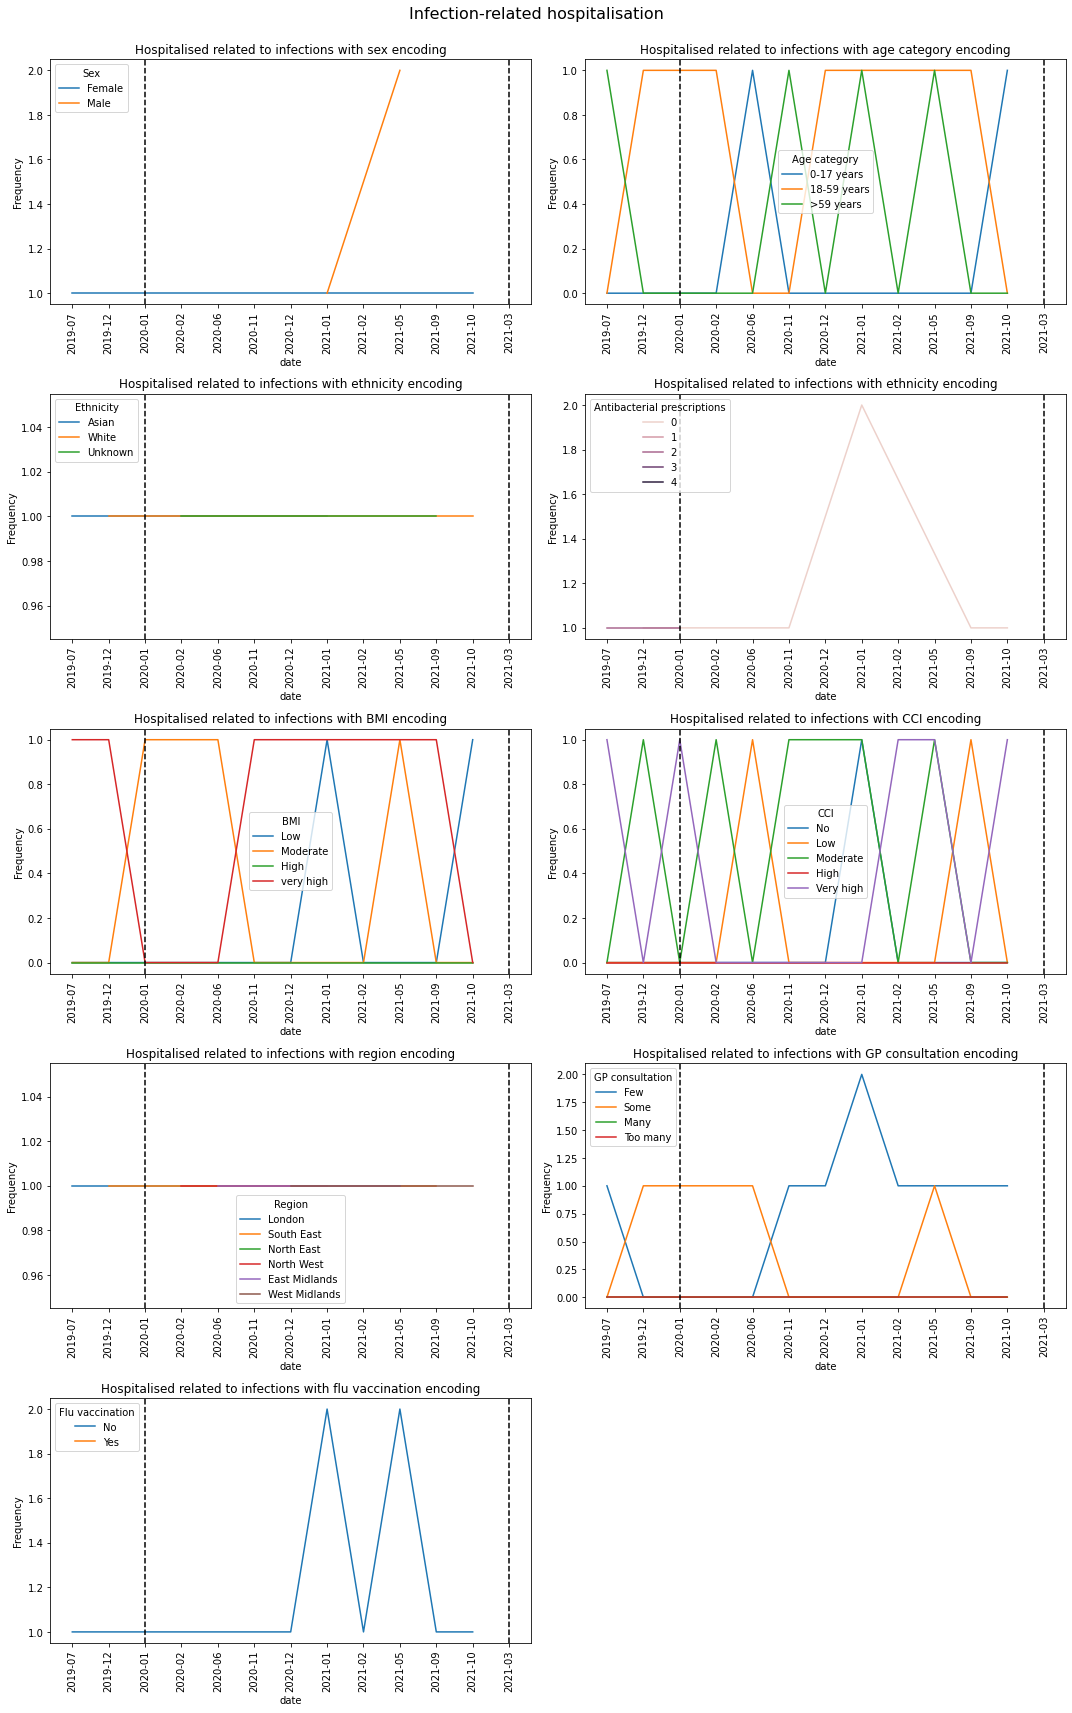

In [117]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )

create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'sex', 'Hospitalised related to infections with sex encoding', 'Sex', axes[0,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Age_cat', 'Hospitalised related to infections with age category encoding', 'Age category', axes[0,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'ethnicity', 'Hospitalised related to infections with ethnicity encoding', 'Ethnicity', axes[1,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'antibacterial_prescriptions', 'Hospitalised related to infections with ethnicity encoding', 'Antibacterial prescriptions', axes[1,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'BMI_cat', 'Hospitalised related to infections with BMI encoding', 'BMI', axes[2,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'CCI_cat', 'Hospitalised related to infections with CCI encoding', 'CCI', axes[2,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'region', 'Hospitalised related to infections with region encoding', 'Region', axes[3,0])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'gp_count_cat', 'Hospitalised related to infections with GP consultation encoding', 'GP consultation', axes[3,1])
create_lineplot_hue('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'flu_vaccine', 'Hospitalised related to infections with flu vaccination encoding', 'Flu vaccination', axes[4,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx1_dat', 'Hospitalised related to infections with encoding of 1st Covid-19 Vaccine', '1st dose of Covid-19 vaccination', axes[5,0])
# create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'covrx2_dat', 'Hospitalised related to infections with encoding of 2nd Covid-19 Vaccine', '2nd dose of Covid-19 vaccination', axes[5,1])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Infection-related hospitalisation', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation_inclusion_exclusion_applied.jpg')
plt.show()

In [196]:
data_inclusions_exlusions.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

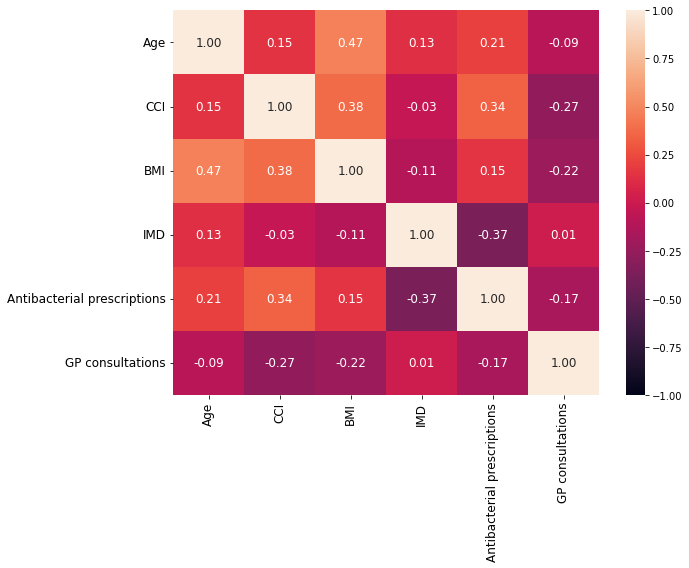

In [214]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_inclusions_exlusions[['age','CCI','bmi', 'imd', 'antibacterial_prescriptions', 'gp_count']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age','CCI','BMI', 'IMD', 'Antibacterial prescriptions', 'GP consultations'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age','CCI','BMI', 'IMD', 'Antibacterial prescriptions', 'GP consultations'], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/corr_hospitalisation.jpg')
plt.show()

In [279]:
# # select patients whom their delta date is between 90 and -30
# data_hosp = data[~data['delta_primary_care_covid_admitted'].isnull()]
# data_hosp.head()

### 3-4- Negative binomial regression

In [40]:
data_inclusions_exlusions#['delta_primary_care_covid_admitted_abs']

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,Infection_admitted_min_delta,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
6725,2021-06,NaN,NaN,2018-10,NaN,NaN,2019-11-27,NaT,NaN,NaN,...,NaN,NaN,22.0,NaN,1.0,22.0,-165.0,165.0,1.0,1.0
11734,2019-11,NaN,NaN,NaN,NaN,NaN,2021-03-19,NaT,NaN,NaN,...,NaN,NaN,7.0,NaN,1.0,7.0,149.0,149.0,1.0,1.0
12511,2021-04,NaN,NaN,NaN,NaN,NaN,2020-06-20,2021-07-01,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,21.0,-71.0,71.0,1.0,1.0
13267,2021-08,NaN,2020-07,2018-04,NaN,NaN,2021-09-07,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,26.0,-187.0,187.0,1.0,1.0
17036,2019-01,NaN,NaN,2018-11,NaN,NaN,2020-07-17,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,29.0,-24.0,24.0,1.0,1.0
22941,2021-12,NaN,2021-05,NaN,NaN,NaN,2019-03-22,NaT,NaN,NaN,...,26.0,NaN,NaN,NaN,1.0,26.0,231.0,231.0,1.0,1.0
23847,2021-04,NaN,NaN,NaN,NaN,NaN,2020-06-12,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,3.0,52.0,52.0,1.0,1.0
24215,2020-11,NaN,2019-07,NaN,NaN,NaN,2019-05-15,NaT,NaN,NaN,...,NaN,13.0,NaN,NaN,1.0,13.0,227.0,227.0,1.0,1.0
24900,2019-11,NaN,NaN,NaN,NaN,NaN,2020-10-16,NaT,NaN,NaN,...,NaN,9.0,NaN,NaN,1.0,9.0,244.0,244.0,1.0,1.0
25968,2021-04,NaN,2021-08,NaN,2018-12,NaN,2020-11-07,NaT,NaN,NaN,...,7.0,NaN,NaN,NaN,1.0,7.0,-19.0,19.0,1.0,1.0


In [324]:
# # assigning 0 to NaN cells of delta_primary_care_covid_admitted_abs for compatibility of NB model
# data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted_abs'].fillna(0)
# data['delta_primary_care_covid_admitted_abs'].value_counts()

In [118]:
# define dictionaries

# dict_sex = {'Female': 1, 'Male': 2}
# dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
# dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
dict_flu = {'No': 0, 'Yes': 1}
#dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# reoplace values of dictionaries with existing ones

# data_inclusions_exlusions = data_inclusions_exlusions.replace({"sex": dict_sex})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"ethnicity": dict_ethnicity})
# data_inclusions_exlusions = data_inclusions_exlusions.replace({"smoking_status": dict_smoking})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"imd": dict_imd})
data_inclusions_exlusions = data_inclusions_exlusions.replace({"flu_vaccine": dict_flu})

In [119]:
data_inclusions_exlusions.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [218]:
data_NB = data_inclusions_exlusions.groupby(['Infection_admitted_min_delta']).sum()#.reset_index()
#data_NB = data_NB.drop([0])
data_NB#.head()

,covrx1_dat,covrx2_dat,age,practice,imd,bmi,gp_count,flu_vaccine_tpp,flu_vaccine,antibacterial_prescriptions,...,delta_uti_4_admitted,delta_lrti_1_admitted,delta_lrti_2_admitted,delta_lrti_3_admitted,delta_lrti_4_admitted,Infection_count,delta_sgss_covid_admitted,delta_sgss_covid_admitted_abs,delta_sgss_covid_admitted_binary,Infection_admitted_min_delta_delta_sgss_covid_admitted_binary
Infection_admitted_min_delta,,,,,,,,,,,,,,,,,,,,,
3.0,0.0,0.0,44,22,2,31.979832,0.0,0,0,4,...,0.0,0.0,0.0,0.0,0.0,1.0,52.0,52.0,1.0,1.0
7.0,0.0,0.0,118,86,11,106.036427,7.0,0,0,1,...,0.0,7.0,7.0,7.0,0.0,3.0,5.0,293.0,3.0,3.0
9.0,0.0,0.0,26,17,2,15.429546,0.0,0,0,0,...,0.0,0.0,9.0,0.0,0.0,1.0,244.0,244.0,1.0,1.0
11.0,0.0,0.0,31,28,2,41.405060,0.0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,1.0,-275.0,275.0,1.0,1.0
12.0,0.0,0.0,72,22,4,24.203253,4.0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,1.0,-137.0,137.0,1.0,1.0
13.0,0.0,0.0,78,24,2,46.731807,0.0,0,0,0,...,0.0,0.0,13.0,0.0,0.0,1.0,227.0,227.0,1.0,1.0
21.0,0.0,0.0,58,24,2,22.876547,4.0,0,1,2,...,0.0,0.0,0.0,0.0,0.0,1.0,-71.0,71.0,1.0,1.0
22.0,0.0,0.0,70,29,4,43.661804,0.0,0,0,2,...,0.0,0.0,0.0,22.0,0.0,1.0,-165.0,165.0,1.0,1.0
26.0,0.0,0.0,120,46,10,49.527044,5.0,0,0,0,...,26.0,26.0,0.0,0.0,0.0,2.0,44.0,418.0,2.0,2.0


In [219]:
# data_NB = data_inclusions_exlusions.groupby(['admitted_date', 'Infection_admitted_min_delta']).mean()#.reset_index()
# #data_NB = data_NB.drop([0])
# data_NB#.head()

In [293]:
# data_NB.index#.admitted_date

In [220]:
X = data_NB[['Infection_count'
#          'age', 
#          'sex',
#           'bmi',
#          'ethnicity', 
#          'smoking_status',
            # 'gp_count',
            # 'CCI',
            # 'imd',
            # 'flu_vaccine',
            # 'antibacterial_prescriptions',
#          'delta_primary_care_covid_admitted_abs',
          ]]

y = data_NB.index
#y = data_NB.index.get_level_values(1) 

In [223]:
nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

In [224]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   11
Model:                            GLM   Df Residuals:                       10
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47.361
Date:                Fri, 10 Dec 2021   Deviance:                       14.240
Time:                        18:59:47   Pearson chi2:                     9.10
No. Iterations:                    11   Pseudo R-squ. (CS):             -1.615
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Infection_count     2.3567      0.217     10.845      0.000       1.931       2.783
===================================================================================
"""

In [48]:
# nb2_training_results.summary2()

In [292]:
# nb2_training_results.conf_int()

In [291]:
# err_series = nb2_training_results.params - nb2_training_results.conf_int()[0]
# err_series

In [290]:
# coef_df = pd.DataFrame({'coef': nb2_training_results.params.values[0:],
#                         'err': err_series.values[0:],
#                         'varname': err_series.index.values[0:]
#                        })
# coef_df

##### 3-4-1- Plot effect of predictors

In [289]:
# fig, ax = plt.subplots(figsize=(8, 5))
# fig.suptitle('Effect of predictors on hospitalisation', fontsize=16)
# ax.errorbar(x=coef_df['coef'], y=coef_df['varname'], xerr=coef_df['err'], fmt='o', color='black',
#              ecolor='darkgray', elinewidth=3)
# # ax1.set_title('variable, asymmetric error')
# # ax1.set_yscale('log')
# ax.axvline(x=0, linestyle='--', color='black', linewidth=2)
# #ax.xaxis.set_ticks_position('none')
# _ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=0, fontsize=12)

# plt.xlabel('', fontsize='14')
# # plt.ylim(0,10)
# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/effect_hospitalisation.jpg')
# plt.show()

In [288]:
# fig, ax = plt.subplots(figsize=(8, 5))
# fig.suptitle('Effect of predictors on hospitalisation', fontsize=16)
# coef_df.plot(x='varname', y='coef', kind='bar', 
#              ax=ax, color='none', 
#              yerr='err', legend=False)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
#            marker='s', s=120, 
#            y=coef_df['coef'], color='black')
# ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
# #ax.xaxis.set_ticks_position('none')
# _ = ax.set_xticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')

# plt.tight_layout()
# #plt.savefig('../output/hospitalisation_risk/effect_hospitalisation_vert.jpg')
# plt.show()

##### 3-4-2- Plot predictions and actual values

In [225]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [226]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

                                     mean     mean_se  mean_ci_lower  \
Infection_admitted_min_delta                                           
3.0                             10.556050    2.293821       6.895029   
7.0                           1176.262722  766.802624     327.799473   
9.0                             10.556050    2.293821       6.895029   
11.0                            10.556050    2.293821       6.895029   
12.0                            10.556050    2.293821       6.895029   
13.0                            10.556050    2.293821       6.895029   
21.0                            10.556050    2.293821       6.895029   
22.0                            10.556050    2.293821       6.895029   
26.0                           111.430195   48.427370      47.541422   
27.0                            10.556050    2.293821       6.895029   
29.0                            10.556050    2.293821       6.895029   

                              mean_ci_upper  
Infection_admitte

In [227]:
#X = X.apply(lambda x: x.sort_values(ascending=False))
#X

In [228]:
#X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]

In [274]:
X

,Infection_count
Infection_admitted_min_delta,
3.0,1.0
7.0,3.0
9.0,1.0
11.0,1.0
12.0,1.0
13.0,1.0
21.0,1.0
22.0,1.0
26.0,2.0


In [266]:
nb2predictions_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
Infection_admitted_min_delta,,,,
3.0,10.556050,2.293821,6.895029,16.160947
7.0,1176.262722,766.802624,327.799473,4220.854841
9.0,10.556050,2.293821,6.895029,16.160947
11.0,10.556050,2.293821,6.895029,16.160947
12.0,10.556050,2.293821,6.895029,16.160947
13.0,10.556050,2.293821,6.895029,16.160947
21.0,10.556050,2.293821,6.895029,16.160947
22.0,10.556050,2.293821,6.895029,16.160947
26.0,111.430195,48.427370,47.541422,261.176207


In [262]:
nb2predictions_summary_frame['mean']

Infection_admitted_min_delta
3.0       10.556050
7.0     1176.262722
9.0       10.556050
11.0      10.556050
12.0      10.556050
13.0      10.556050
21.0      10.556050
22.0      10.556050
26.0     111.430195
27.0      10.556050
29.0      10.556050
Name: mean, dtype: float64

In [265]:
y

Float64Index([3.0, 7.0, 9.0, 11.0, 12.0, 13.0, 21.0, 22.0, 26.0, 27.0, 29.0], dtype='float64', name='Infection_admitted_min_delta')

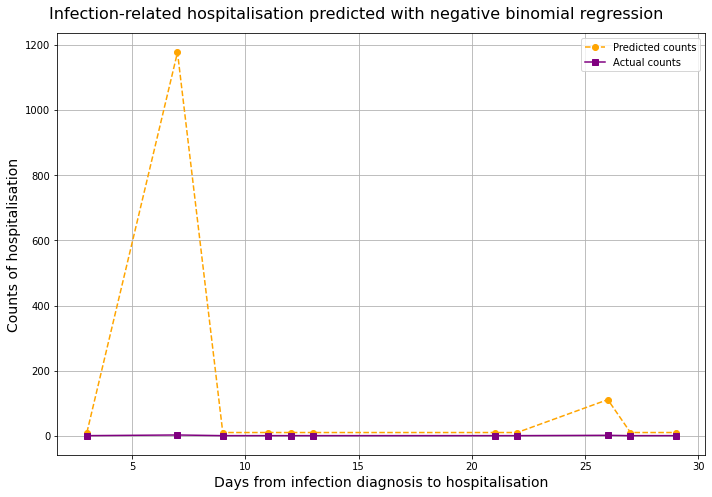

In [270]:
# NB_predicted_counts = nb2predictions_summary_frame['mean'].drop([0])*1000
NB_predicted_counts = nb2predictions_summary_frame['mean']#*1000
# actual_counts = y.drop([0])*1000
actual_counts = y#y#*1000

fig = plt.figure(figsize=(10, 7))
fig.suptitle('Infection-related hospitalisation predicted with negative binomial regression', fontsize=16)
predicted, = plt.plot(actual_counts, NB_predicted_counts, color='orange', ls='--', marker='o', label='Predicted counts',
                    #'go--', 
                    )
actual, = plt.plot(actual_counts, X.Infection_count, color='purple', ls='solid', marker='s', label='Actual counts'
                    #'ro-', 
                    )
#plt.ylim(-0.1,1.1)

# plt.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# plt.axvline(x="2021-03", color='black', ls='--', lw=1.5)

plt.legend(handles=[predicted, actual])
# plt.xticks(rotation=90,) 
#             #ha='right')
plt.grid()
plt.ylabel('Counts of hospitalisation', fontsize='14')
plt.xlabel('Days from infection diagnosis to hospitalisation', fontsize='14')
# plt.ylim(0,10)
plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

##### 3-4-3- Other plots

In [ ]:
# # see: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLMResults.html

# # added variable plot for a fitted regression model
# nb2_training_results.plot_added_variable('age')

# nb2_training_results.plot_ceres_residuals('age')

# nb2_training_results.plot_partial_residuals('age')

In [348]:
# # #Influence Measures for GLM Logit
# # #https://www.statsmodels.org/stable/examples/notebooks/generated/influence_glm_logit.html

# NB2 = nb2_training_results.get_influence(observed=False)

# NB2_sum = NB2.summary_frame()
# NB2_sum.sort_values("cooks_d", ascending=False)[:10]

# # fig = NB2.plot_influence()
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="cooks", threshold=2 * infl.cooks_distance[0].mean())
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="resid", threshold=1)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=1, threshold=0.5)
# # fig.tight_layout(pad=1.0)

# # fig = NB2.plot_index(y_var="dfbeta", idx=2, threshold=0.5)
# # fig.tight_layout(pad=1.0)

## Questions:
Q1- should we not exclude those who are admitted due to covid, not those who were diagnosed with covid 3 months before or two weeks after?

Q2- what is the difference between primary_care_covid and sgss_positive? seems like the first one is broader, right?

Q3- Data for NB2 model is not split into training and testing. Is it OK or it should be split?

Q4- I have used groupby to create data set for NB2. It calculates a mean value for each variable in each month. How is this gonna work with categorical variables?

Q5- If a patient gets hospitalise twice or more, I assume we consider the one that was closer to the infection diagnosis date, right?